<a href="https://colab.research.google.com/github/iqbalamo93/keras_RNN/blob/master/RNN_TimeSeries_RSCCASN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
url ='https://raw.githubusercontent.com/iqbalamo93/Datasets/master/RSCCASN.csv'

In [3]:
df = pd.read_csv(url,parse_dates=True,index_col='DATE')

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.rename(columns={'RSCCASN': 'Sales'},inplace=True)

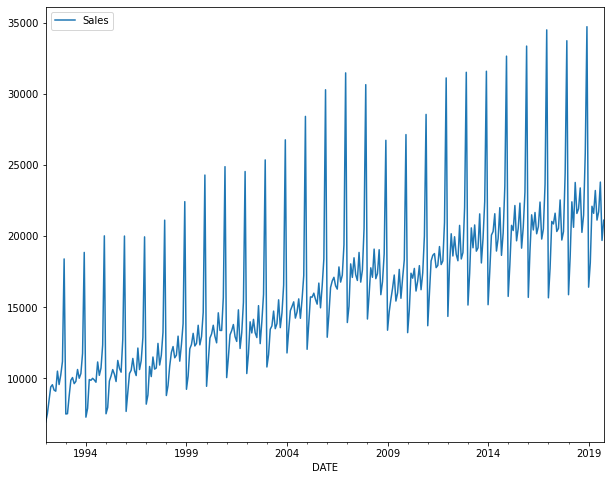

In [7]:
df.plot(figsize=(10,8))

In [8]:
len(df)

334

In [9]:
#18 rows=15.yesrs
len(df)-18

316

In [10]:
test_size=18
test_index = len(df)-test_size

In [11]:
train = df.iloc[:test_index]
test  = df.iloc[test_index:]

In [12]:
len(test)

18

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import  TimeseriesGenerator

In [19]:
len(test)

18

In [20]:
length = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [21]:
len(generator)

304

In [22]:
len(scaled_train)

316

In [23]:
316-12

304

In [24]:
from tensorflow.keras.models import Sequential

In [25]:
from tensorflow.keras.layers import Dense,LSTM

In [26]:
n_features = 1

In [27]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop  = EarlyStopping(monitor='val_loss',patience=2)

In [31]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                           batch_size=1,length=length)

In [32]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0254 - val_loss: 0.0079
Epoch 2/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0158 - val_loss: 0.0119
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 4/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0037 - val_loss: 3.0750e-04
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0028 - val_loss: 3.0191e-04
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 7/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0014 - val_loss: 7.2662e-04


In [33]:
losses = pd.DataFrame(model.history.history)

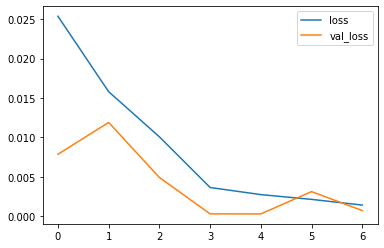

In [34]:
losses.plot()

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21816.907478
2018-06-01,21589,20460.739614
2018-07-01,21919,20692.512896
2018-08-01,23381,22880.917662
2018-09-01,20260,20010.018402
2018-10-01,21473,20724.557400
2018-11-01,25831,25443.676802
2018-12-01,34706,37350.180522
2019-01-01,16410,16263.391453


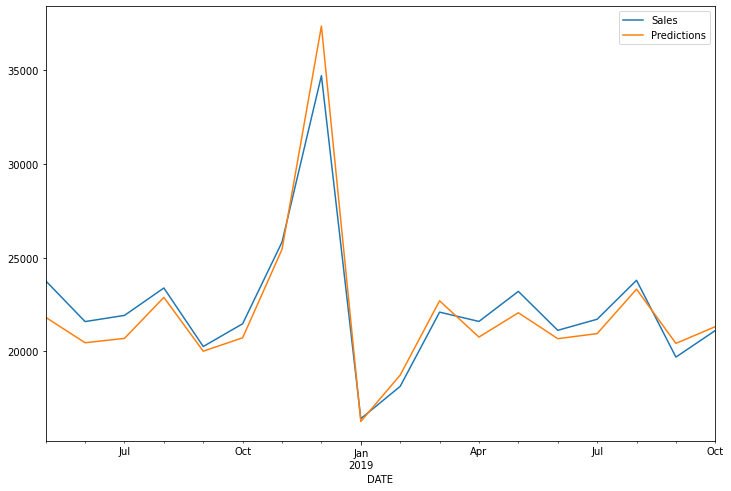

In [39]:
test.plot(figsize=(12,8))

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length =12
generator = TimeseriesGenerator(
    scaled_full_data,scaled_full_data,length=length,batch_size=1
)

In [48]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [49]:
model.fit_generator(generator, epochs=8 )

Epoch 1/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0261
Epoch 2/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0162
Epoch 3/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0078
Epoch 4/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0030
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0033
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0015


In [61]:
forecast = []
period = 12
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(period):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [62]:
forecast = full_scaler.inverse_transform(forecast)

In [63]:
forecast_index = pd.date_range(start='2019-11-01',
                               periods=periods,freq='MS' )

In [64]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [65]:
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,columns=['Forecast'])

In [67]:
forecast_df

,Forecast
2019-11-01,25429.379639
2019-12-01,34274.786404
2020-01-01,16915.582445
2020-02-01,18251.262819
2020-03-01,21731.375810
2020-04-01,21285.878685
2020-05-01,22834.191639
2020-06-01,20897.651392
2020-07-01,21470.910788
2020-08-01,23392.197618


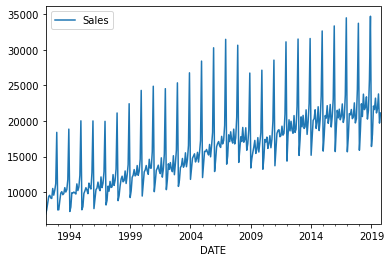

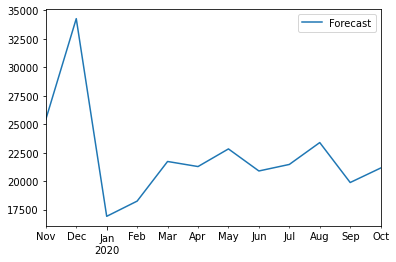

In [69]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

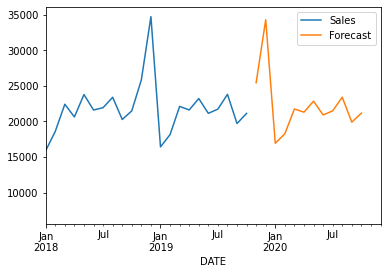

In [71]:
ax =df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')